Features Importnce...
Feature ranking:


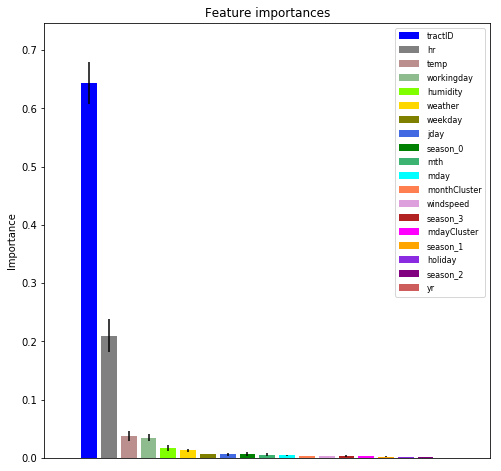

In [2]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder

from scipy import sparse 
from math import *

from matplotlib import cm
import matplotlib.pyplot as plt

import sklearn.cluster as cluster
import statsmodels.api as sm

import pandas as pd
import numpy as np
import datetime as dt

# =====================================================================

ifile = "D:/Capston/2013_Hour_By_Tract.csv"
pngfile = "D:/Capston/Features_Importance"

features = ['tractID','hr','yr','jday','mday','mth','mdayCluster','monthCluster','weekday','holiday','workingday','temp','weather','season_0','season_1','season_2','season_3','humidity','windspeed']
colors = ['blue','grey','rosybrown','darkseagreen','chartreuse','gold','olive','royalblue','green','mediumseagreen','aqua','coral','plum','firebrick','fuchsia','orange','blueviolet','purple','indianred','magenta','teal']

# =====================================================================

def read_data():
    ds = pd.read_csv(ifile, sep=',', header=0)

    return ds


def remove_columns(ds, drop_cols):
    ds = ds.drop(drop_cols, axis = 1)

    return ds

# =====================================================================

def split_list(alist, wanted_parts = 1):
    length = len(alist)
    return [ alist[i * length // wanted_parts: (i + 1) * length // wanted_parts]
            for i in range(wanted_parts) ]


def data_cluster(df, grpBy, cluster_num):
    
    cluster_data = df.groupby([grpBy]).agg(lambda x: x.mean())[['cnt']]
    model = cluster.KMeans(n_clusters = cluster_num)
    
    return np.array(model.fit_predict(split_list(cluster_data.iloc[:,0].values, len(cluster_data))))


def transform_data(df):

    df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')
    df['mday'] = df['dteday'].dt.day 
   
    ds = df.loc[:,['mth', 'mday']].values
    month_cluster_values = []
    mday_cluster_values = []
    
    month_clusters = data_cluster(df, 'mth', 9)
    mday_clusters = data_cluster(df, 'mday', 11)
    
    for mth, mday in ds:
        month_cluster_values.append(month_clusters[mth - 1])
        mday_cluster_values.append(mday_clusters[mday - 1])
        
    df['monthCluster'] = month_cluster_values
    df['mdayCluster'] = mday_cluster_values

    enc = OneHotEncoder(sparse=False)  
    n = df['weather'].shape[0]
    enc_array = pd.DataFrame(sparse.csr_matrix(enc.fit_transform(df['season'].values.reshape(-1, 1))).todense().reshape(n, 1, 4))
    df['season_0'] = enc_array[[0]]
    df['season_1'] = enc_array[[1]] 
    df['season_2'] = enc_array[[2]] 
    df['season_3'] = enc_array[[3]] 

    df['casual'] = [log1p(x) for x in df['casual']]
    df['registered'] = [log1p(x) for x in df['registered']]
    df['cnt'] = [log1p(x) for x in df['cnt']]

    df['tractID'] = MinMaxScaler().fit_transform(df['tractID'].astype(float).values.reshape(-1, 1))
    df['hr'] = StandardScaler().fit_transform(df['hr'].astype(float).values.reshape(-1, 1))
    df['weekday'] = StandardScaler().fit_transform(df['weekday'].astype(float).values.reshape(-1, 1))
    df['weather'] = StandardScaler().fit_transform(df['weather'].astype(float).values.reshape(-1, 1))
    df['temp'] = StandardScaler().fit_transform(df['temp'].values.reshape(-1, 1))
    df['windspeed'] = [log1p(x) for x in df['windspeed']]
    df['humidity'] = [log1p(x) for x in df['humidity']]

    return df

# =====================================================================

def features_importance(model, pngfile):
    X_data, y_data = bike[features], bike[['cnt']]

    model.fit(X_data, y_data.values.ravel())
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
    indices = np.argsort(importances)[::-1]
    labels = np.array(X_data.columns.values)
    print("Feature ranking:")

    fig, ax = plt.subplots(figsize = (8, 8))
    fi = ax.bar(range(X_data.shape[1]), importances[indices],
                color=colors, yerr=std[indices], align="center")
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title('Feature importances')
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_visible(False)
    #ax.set_xticklabels(labels[indices], rotation = 'vertical', 
    #                   fontsize=7, minor = False)
    plt.margins(0.1)
    #plt.subplots_adjust(bottom=0.2)

    legend = ax.legend(fi, labels[indices], loc = 1)
    frame = legend.get_frame()
    for label in legend.get_texts():
        label.set_fontsize(8)

    plt.savefig(pngfile)
    plt.show()

# =====================================================================

bike = read_data()
bike = transform_data(bike)

# Feacture importances
print("Features Importance...")
model = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto',
                            max_depth = 28, min_samples_split = 45,
                            random_state = 0)
features_importance(model, pngfile + "ExtraTrees.png")

